In [6]:
import numpy as np
import pyGMs as gm
import matplotlib.pyplot as plt

import requests                                      # reading data
from io import StringIO
import time

In [7]:
# Load the features and labels from an online text file
tr_url = 'https://sli.ics.uci.edu/extras/cs179/data/cs179-hw5-train.csv'
te_url = 'https://sli.ics.uci.edu/extras/cs179/data/cs179-hw5-test.csv'

with requests.get(tr_url) as link: titles = StringIO(link.text).readline()[2:].strip().split(',')
with requests.get(tr_url) as link: Xtr = np.loadtxt(StringIO(link.text),delimiter=',')
with requests.get(te_url) as link: Xte = np.loadtxt(StringIO(link.text),delimiter=',')
    
# It's helpful to have a list of "short" names for display purposes:
short = {0:'ToyStory',1:'Aladdin ',2:'Cars    ',3:'Potter2 ',4:'Potter3 ',5:'DieHard ',
         6:'Aliens  ',7:"Gremlins",8:"LWomen  ",9:"BoysSide"}

In [8]:
Xtr = (Xtr >= 7).astype(int);   # did each user like the movie?  (binary)
Xte = (Xte >= 7).astype(int);

# (use any threshold you like, but "7+" might be "worth recommending"?)
mUsers, nMovies = Xtr.shape

In [9]:
pXi = np.mean(1.*Xtr,axis=0);  # empirical probability of liking each movie individually

# We don't really need a graphical model for this, but we might as well:
model0 = gm.GraphModel( [gm.Factor([gm.Var(i,2)],[1-pXi[i],pXi[i]]) for i in range(nMovies)])

In [10]:
# How well does our model fit the data?
print("Independent model Train LL: ",np.mean([model0.logValue(x) for x in Xtr]))
print("Independent model Test  LL: ",np.mean([model0.logValue(x) for x in Xte]))

Independent model Train LL:  -6.38742095180935
Independent model Test  LL:  -5.718156517917562


### Learn an Ising model
There are lots of methods to learn Ising models, or the "support structure" (which edges have non-zero parameter values) for an Ising model. One trivial way is based on the observation that each variable's conditional distribution is given by a logistic regression model, with coefficients equal to twice the Ising model parameters. So we can estimate the parameters, or their support, using logistic regression, and encourage a sparse model (few dependencies) by adding a sparse penalty to the regression, for example  𝐿1  regularization:

In [11]:
# Find adjacency graph using penalized logistic regression

from sklearn.linear_model import LogisticRegression

# for each Xi, estimate the neighborhood of Xi using L1-reg logistic regression:
C = 50./100  # inverse regularization penalty: smaller => sparser weights
nbrs,th_ij,th_i = [None]*nMovies, [None]*nMovies, np.zeros((nMovies,))
Xtmp = np.copy(Xtr)  # we'll be messing with the matrix
for i in range(nMovies):  
    Xtmp[:,i] = 0.      # remove ourselves
    lr = LogisticRegression(penalty='l1',C=C,solver='liblinear').fit(Xtmp,Xtr[:,i])
    nbrs[i] = np.where(np.abs(lr.coef_) > 1e-6)[1]
    th_ij[i]= lr.coef_[0,nbrs[i]]/2.
    th_i[i] = lr.intercept_/2.
    Xtmp[:,i] = Xtr[:,i]; # & restore after

/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_63209/1393317709.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_/2.
/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_63209/1393317709.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_/2.
/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_63209/1393317709.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_/2.
/

Depending on how much regularization we apply, this will give more or fewer neighbors for each variable:

In [12]:
print("Average connectivity at C=",C,": ")
print(np.mean([len(nn) for nn in nbrs])," +/- ",np.std([len(nn) for nn in nbrs]))

Average connectivity at C= 0.5 : 
3.6  +/-  0.8


In [13]:
# Collect single-variable factors
factors1 = [gm.Factor(gm.Var(i,2),[-t,t]).exp() for i,t in enumerate(th_i)]

# Collect non-zero pairwise factors
for i in range(nMovies):
    for j,n in enumerate(nbrs[i]):
        scope = [gm.Var(i,2),gm.Var(int(n),2)]
        t = th_ij[i][j]
        factors1.append( gm.Factor(scope, [[t,-t],[-t,t]]).exp() )

# Build a model from the factors
model1 = gm.GraphModel(factors1)
model1.makeMinimal()


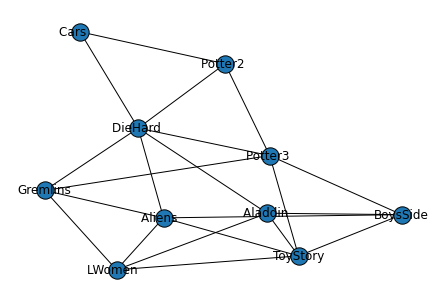

In [14]:
gm.drawMarkovGraph(model1,labels=short);


In [15]:
# How well does our model fit the data?  Now we need to know the partition function!
# Maybe we can do it using variable elimination?  Depends on the treewidth.
order,val = gm.eliminationOrder(model1, 'minfill')
# (actually "val" here is an estimate of the required memory, so that's even better, but...)

pt = gm.PseudoTree(model1,order)                   # find the tree width:
print("Induced width of order found: ",pt.width)# 16 is not too bad (2^16 = 65k), so we can do it:
import pyGMs.wmb
jt = gm.wmb.JTree(model1, elimOrder=order)
lnZ = jt.msgForward()
print("Log partition f'n: ",lnZ)

Induced width of order found:  4
Log partition f'n:  10.125551793567332


In [16]:
# 16 is not too bad (2^16 = 65k), so we can do it:
import pyGMs.wmb
jt = gm.wmb.JTree(model1, elimOrder=order)
lnZ = jt.msgForward()
print("Log partition f'n: ",lnZ)

Log partition f'n:  10.125551793567332


In [17]:
# Now we can calculate the actual log-likelihood of the data:
print("LogReg Ising Train LL: ",np.mean([model1.logValue(x) for x in Xtr]) - lnZ)
print("LogReg Ising Test  LL: ",np.mean([model1.logValue(x) for x in Xte]) - lnZ)

LogReg Ising Train LL:  -7.334083336515478
LogReg Ising Test  LL:  -4.890299892881683


# Evaluating model quality
We can evaluate our models either through the test data likelihood, or through predictive accuracy.
If the induced width of a model is too high, we may be unable to exactly evaluate its log likelihood. One option then is to evaluate its pseudo-likelihood, and compare this between models:

In [18]:
def conditional(factor,i,x):
    return factor.t[tuple(x[v] if v!=i else slice(v.states) for v in factor.vars)]

def pseudolikelihood(model,X):
    LL = np.zeros( X.shape )
    for i in range(X.shape[1]):  # for each variable:
        flist = model.factorsWith(i, copy=False)
        for j in range(X.shape[0]):
            pXi = 1.
            for f in flist: pXi *= conditional(f,i,X[j])
            LL[j,i] = np.log( pXi[X[j,i]]/pXi.sum() ); 
    return LL.sum(1);

In [19]:
pseudolikelihood(model0, Xte).mean()


-5.718156517917562

In [20]:
pseudolikelihood(model1, Xte).mean()


-5.340737217642248

# Making predictions given the Ising model parameters:
Once we have an ising model, we can use our "missing value" test dataset to predict whether the user will like the withheld movies given the observed movie likes. We can condition the model on the known observation values, leaving a model only over the unknown movies, and then perform an argmax query to predict their values. If the induced width is small enough, we can just do this with exact inference:

In [21]:
def impute_missing(model, Xobs):
    m,n = Xobs.shape
    Xhat = np.copy(Xobs);
    for j in range(m):
        x_obs = {i:Xobs[j,i] for i in range(n) if Xobs[j,i] >= 0}
        x_unobs = [i for i in range(n) if Xobs[j,i] < 0]
        cond = gm.GraphModel([f.condition(x_obs) for f in model.factorsWithAny(x_unobs)])
        for x in cond.X:
            if x.states == 0: x.states = 1;  # fix a bug in GraphModel behavior for missing vars...
        jt = gm.wmb.JTree(cond, weights=1e-6) # 0: for maximization
        x_hat = jt.argmax();
        for i in x_unobs: Xhat[j,i] = x_hat[i]
    return Xhat

In [22]:
# # Slow!  (Constructing lots of conditional models...)
Xte_hat = impute_missing(model1, Xte_missing)
print('Error rate:', np.mean( (Xte_hat!=Xte_missing)[Xte_hat<0] ) )